## How often does ROCES outperform the state of the art without requiring all examples to be used?

In [3]:
import os, random
from utils.simple_solution import SimpleSolution
from utils.evaluator import Evaluator
from utils.data import Data
from ontolearn.knowledge_base import KnowledgeBase
from owlapy.render import DLSyntaxObjectRenderer
from roces import BaseConceptSynthesis
from roces.synthesizer import ConceptSynthesizer
from owlapy.parser import DLSyntaxParser
from utils.dataset import DatasetInference
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from tqdm import tqdm
import json
import torch
import numpy as np, time
from collections import defaultdict
import re
from argparse import Namespace


def build_roces_vocabulary(data_train, data_test, kb, args):
    def add_data_values(path):
        print("\n*** Finding relevant data values ***")
        values = set()
        for ce, lp in data_train+data_test:
            if '[' in ce:
                for val in re.findall("\[(.*?)\]", ce):
                    values.add(val.split(' ')[-1])
        print("*** Done! ***\n")
        print("Added values: ", values)
        print()
        return list(values)
    renderer = DLSyntaxObjectRenderer()
    individuals = [ind.get_iri().as_str().split("/")[-1] for ind in kb.individuals()]
    atomic_concepts = list(kb.ontology().classes_in_signature())
    atomic_concept_names = [renderer.render(a) for a in atomic_concepts]
    role_names = [rel.get_iri().get_remainder() for rel in kb.ontology().object_properties_in_signature()] + \
                 [rel.get_iri().get_remainder() for rel in kb.ontology().data_properties_in_signature()]
    vocab = atomic_concept_names + role_names + ['⊔', '⊓', '∃', '∀', '¬', '⊤', '⊥', '.', ' ', '(', ')',\
                                                '⁻', '≤', '≥', 'True', 'False', '{', '}', ':', '[', ']',
                                                'double', 'integer', 'date', 'xsd']
    quantified_restriction_values = [str(i) for i in range(1,12)]
    data_values = add_data_values(args.knowledge_base_path)
    vocab = vocab + data_values + quantified_restriction_values
    vocab = sorted(set(vocab)) + ['PAD']
    print("Vocabulary size: ", len(vocab))
    num_examples = min(args.num_examples, kb.individuals_count()//2)
    return vocab, num_examples


def before_pad(arg):
    arg_temp = []
    for atm in arg:
        if atm == 'PAD':
            break
        arg_temp.append(atm)
    return arg_temp

def compute_accuracy(prediction, target):
    def soft(arg1, arg2):
        arg1_ = arg1
        arg2_ = arg2
        if isinstance(arg1_, str):
            arg1_ = set(before_pad(BaseConceptSynthesis.decompose(arg1_)))
        else:
            arg1_ = set(before_pad(arg1_))
        if isinstance(arg2_, str):
            arg2_ = set(before_pad(BaseConceptSynthesis.decompose(arg2_)))
        else:
            arg2_ = set(before_pad(arg2_))
        return 100*float(len(arg1_.intersection(arg2_)))/len(arg1_.union(arg2_))

    def hard(arg1, arg2):
        arg1_ = arg1
        arg2_ = arg2
        if isinstance(arg1_, str):
            arg1_ = before_pad(BaseConceptSynthesis.decompose(arg1_))
        else:
            arg1_ = before_pad(arg1_)
        if isinstance(arg2_, str):
            arg2_ = before_pad(BaseConceptSynthesis.decompose(arg2_))
        else:
            arg2_ = before_pad(arg2_)
        return 100*float(sum(map(lambda x,y: x==y, arg1_, arg2_)))/max(len(arg1_), len(arg2_))
    soft_acc = sum(map(soft, prediction, target))/len(target)
    hard_acc = sum(map(hard, prediction, target))/len(target)
    return soft_acc, hard_acc

num_examples = 1000
def collate_batch(batch):
    pos_emb_list = []
    neg_emb_list = []
    target_labels = []
    for pos_emb, neg_emb, label in batch:
        if pos_emb.ndim != 2:
            pos_emb = pos_emb.reshape(1, -1)
        if neg_emb.ndim != 2:
            neg_emb = neg_emb.reshape(1, -1)
        pos_emb_list.append(pos_emb)
        neg_emb_list.append(neg_emb)
        target_labels.append(label)
    pos_emb_list[0] = F.pad(pos_emb_list[0], (0, 0, 0, num_examples - pos_emb_list[0].shape[0]), "constant", 0)
    pos_emb_list = pad_sequence(pos_emb_list, batch_first=True, padding_value=0)
    neg_emb_list[0] = F.pad(neg_emb_list[0], (0, 0, 0, num_examples - neg_emb_list[0].shape[0]), "constant", 0)
    neg_emb_list = pad_sequence(neg_emb_list, batch_first=True, padding_value=0)
    target_labels = pad_sequence(target_labels, batch_first=True, padding_value=-100)
    return pos_emb_list, neg_emb_list, target_labels

def predict(kb, test_data, models, embedding_models, repeat_pred, args):
    args.path_to_triples = f"datasets/{kb}/Triples/"
    global num_examples
    num_examples = models[0].num_examples
    vocab = models[0].vocab
    inv_vocab = models[0].inv_vocab
    kb_embedding_data = Data(args)
    soft_acc, hard_acc = 0.0, 0.0
    preds = []
    targets = []
    k_values = np.linspace(1+0.1*num_examples, 0.95*num_examples, num=50).astype(int)
    Scores = []
    for j,k in tqdm(enumerate(k_values), total=len(k_values), desc='sampling examples...'):
        test_dataset = DatasetInference(test_data, kb_embedding_data, k, vocab, inv_vocab, args, random_sample=True)
        for i, (model, embedding_model) in enumerate(zip(models, embedding_models)):
            model = model.eval()
            scores = []
            test_dataset.load_embeddings(embedding_model.eval())
            test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=args.num_workers, collate_fn=collate_batch, shuffle=False)
            for x1, x2, labels in tqdm(test_dataloader):
                if i == 0 and j == 0:
                    target_sequence = model.inv_vocab[labels]
                    targets.append(target_sequence)  # The target sequence does not depend on the current model
                _, sc = model(x1, x2)
                scores.append(sc.detach()) 
            scores = torch.cat(scores, 0)
            if i == 0:
                all_scores = scores
            else:
                all_scores = all_scores + scores
        all_scores = all_scores / len(models)
        Scores.append(all_scores)
    pred_sequences = [model.inv_vocab[score.argmax(1)] for score in Scores]
    targets = np.concatenate(targets, 0)
    return pred_sequences, targets


def initialize_synthesizer(vocab, num_examples, num_inds, args):
    args.num_inds = num_inds
    roces = ConceptSynthesizer(vocab, num_examples, args)
    roces.refresh()
    return roces.model, roces.embedding_model

def synthesize_class_expressions(kb, test_data, vocab, num_examples, num_inds, repeat_pred, args):
    args.knowledge_base_path = "datasets/" + f"{kb}/{kb}.owl"
    embs = torch.load(f"datasets/{kb}/Model_weights/SetTransformer_{args.kb_emb_model}_Emb_inducing_points32.pt", map_location=torch.device("cpu"))
    setattr(args, 'num_entities', embs['emb_ent_real.weight'].shape[0])
    setattr(args, 'num_relations', embs['emb_rel_real.weight'].shape[0])
    models, embedding_models = [], []
    for inds in num_inds:
        model, embedding_model = initialize_synthesizer(vocab, num_examples, inds, args)
        if args.sampling_strategy != 'uniform':
            model.load_state_dict(torch.load(f"datasets/{kb}/Model_weights/{args.kb_emb_model}_SetTransformer_inducing_points{inds}.pt", map_location=torch.device("cpu")))
            embedding_model.load_state_dict(torch.load(f"datasets/{kb}/Model_weights/SetTransformer_{args.kb_emb_model}_Emb_inducing_points{inds}.pt", map_location=torch.device("cpu")))
        else:
            model.load_state_dict(torch.load(f"datasets/{kb}/Model_weights/{args.kb_emb_model}_SetTransformer_uniform_inducing_points{inds}.pt", map_location=torch.device("cpu")))
            embedding_model.load_state_dict(torch.load(f"datasets/{kb}/Model_weights/SetTransformer_{args.kb_emb_model}_Emb_uniform_inducing_points{inds}.pt", map_location=torch.device("cpu")))
        models.append(model)
        embedding_models.append(embedding_model)
    return predict(kb, test_data, models, embedding_models, repeat_pred, args)

    
    
def run_experiment(kb_name, args, repeat_pred=False, save_results=False, verbose=False):
    print('#'*50)
    print('ROCES evaluation on {} KB:'.format(kb_name))
    print()
    kb = KnowledgeBase(path=f"datasets/{kb_name}/{kb_name}.owl")
    with open(f"datasets/{kb_name}/Test_data/Data.json", "r") as file:
        test_data = json.load(file)
    with open(f"datasets/{kb_name}/Train_data/Data.json", "r") as file:
        train_data = json.load(file)
    vocab, num_examples = build_roces_vocabulary(train_data, test_data, kb, args)
    namespace = list(kb.individuals())[0].get_iri().get_namespace()
    print("KB namespace: ", namespace)
    print()
    simpleSolution = SimpleSolution(kb)
    evaluator = Evaluator(kb)
    dl_parser = DLSyntaxParser(namespace = namespace)
    all_individuals = set(kb.individuals())
    ensemble_models = "+".join(["SetTransformer_I32", "SetTransformer_I64", "SetTransformer_I128"])
    num_inds = [int(model_name.split("I")[-1]) for model_name in ensemble_models.split("+")]
    predictions, targets = synthesize_class_expressions(kb_name, test_data, vocab, num_examples, num_inds, repeat_pred, args)
    F1 = [list() for _ in range(len(predictions))]
    Acc = [list() for _ in range(len(predictions))]
    Predictions = [list() for _ in range(len(predictions))]
    for i, k_pred in tqdm(enumerate(predictions), total=len(predictions)):
        for j, pb_str in enumerate(targets):
            pb_str = "".join(before_pad(pb_str))
            try:
                end_idx = np.where(k_pred[j] == 'PAD')[0][0] # remove padding token
            except IndexError:
                end_idx = -1
            pred = k_pred[j][:end_idx]
            try:
                prediction = dl_parser.parse("".join(pred.tolist()))
            except Exception:
                try:
                    pred = simpleSolution.predict(k_pred[j].sum())
                    prediction = dl_parser.parse(pred)
                except Exception:
                    print(f"Could not understand expression {pred}")
            if prediction is None:
                prediction = dl_parser.parse('⊤')
            target_expression = dl_parser.parse(pb_str) # The target class expression
            positive_examples = set(kb.individuals(target_expression))
            negative_examples = all_individuals-positive_examples
            try:
                acc, f1 = evaluator.evaluate(prediction, positive_examples, negative_examples)
            except Exception as err:
                print(f"{j}: Parsing error on ", prediction)
                print(err)
                prediction = dl_parser.parse('⊤')
                acc, f1 = evaluator.evaluate(prediction, positive_examples, negative_examples)
            if verbose:
                print(f'Problem {j}, Target: {pb_str}, Prediction: {simpleSolution.renderer.render(prediction)}, Acc: {acc}, F1: {f1}')
                print()
            try:
                prediction_str = simpleSolution.renderer.render(prediction)
            except:
                prediction_str = "Unknown"
            Acc[i].append(acc)
            F1[i].append(f1)
            Predictions[i].append(prediction_str)
    with open(f"datasets/{kb_name}/RQ3_F1.json", "w") as file:
        json.dump({key: val for key,val in enumerate(F1)}, file, ensure_ascii=False)
    with open(f"datasets/{kb_name}/RQ3_Acc.json", "w") as file:
        json.dump({key: val for key,val in enumerate(Acc)}, file, ensure_ascii=False)
    with open(f"datasets/{kb_name}/RQ3_Pred.json", "w") as file:
        json.dump({key: val for key,val in enumerate(Predictions)}, file, ensure_ascii=False)
    return Acc, F1, Predictions

In [2]:
with open("config.json") as config:
    nces_args = json.load(config)
    nces_args = Namespace(**nces_args)
nces_args.kb_emb_model = "ConEx"
nces_args.sampling_strategy = "original" # This corresponds to the probability density functions p+ and p- defined in Algorithm 1

In [3]:
Acc, F1, Predictions = run_experiment("semantic_bible", nces_args)

##################################################
ROCES evaluation on semantic_bible KB:



* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation





*** Finding relevant data values ***
*** Done! ***

Added values:  {'35.583', '44.42', '41.013'}

Vocabulary size:  126
KB namespace:  http://semanticbible.org/ns/2006/NTNames#






100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

100%|████████

Parsing the prediction failed


  4%|▍         | 2/50 [00:00<00:13,  3.61it/s]

Parsing the prediction failed
Parsing the prediction failed


  8%|▊         | 4/50 [00:00<00:09,  4.73it/s]

Parsing the prediction failed
Parsing the prediction failed


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


In [38]:
for kb_name in ["carcinogenesis", "mutagenesis", "vicodi"]:
    run_experiment(kb_name, nces_args);

##################################################
ROCES evaluation on carcinogenesis KB:


*** Finding relevant data values ***
*** Done! ***

Added values:  set()

Vocabulary size:  198
KB namespace:  http://dl-learner.org/carcinogenesis#






100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

100%|██████████| 1/1 [00:02<00:00,  2.45s/it]

100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

100%|██████████| 1/1 [00:02<00:00,  2.11s/it]

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

100%|██████████| 1/1 [00:02<00:00,  2.11s/it]

100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

100%|████████

##################################################
ROCES evaluation on mutagenesis KB:


*** Finding relevant data values ***
*** Done! ***

Added values:  {'1.002', '-0.529', '-1.031', '7.84', '-0.781', '5.39', '-3.768'}

Vocabulary size:  141
KB namespace:  http://dl-learner.org/mutagenesis#






100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

100%|████████

Parsing the prediction failed


 14%|█▍        | 7/50 [00:05<00:30,  1.40it/s]

Parsing the prediction failed


 16%|█▌        | 8/50 [00:06<00:28,  1.46it/s]

Parsing the prediction failed


 18%|█▊        | 9/50 [00:06<00:27,  1.51it/s]

Parsing the prediction failed


 22%|██▏       | 11/50 [00:08<00:24,  1.57it/s]

Parsing the prediction failed


 30%|███       | 15/50 [00:10<00:21,  1.62it/s]

Parsing the prediction failed


 40%|████      | 20/50 [00:13<00:18,  1.63it/s]

Parsing the prediction failed


 42%|████▏     | 21/50 [00:14<00:17,  1.63it/s]

Parsing the prediction failed


 44%|████▍     | 22/50 [00:14<00:17,  1.63it/s]

Parsing the prediction failed


 46%|████▌     | 23/50 [00:15<00:16,  1.63it/s]

Parsing the prediction failed


 48%|████▊     | 24/50 [00:16<00:16,  1.62it/s]

Parsing the prediction failed


 50%|█████     | 25/50 [00:16<00:15,  1.62it/s]

Parsing the prediction failed


 52%|█████▏    | 26/50 [00:17<00:14,  1.61it/s]

Parsing the prediction failed


 54%|█████▍    | 27/50 [00:17<00:14,  1.61it/s]

Parsing the prediction failed


 56%|█████▌    | 28/50 [00:18<00:13,  1.62it/s]

Parsing the prediction failed


 58%|█████▊    | 29/50 [00:19<00:12,  1.62it/s]

Parsing the prediction failed


 60%|██████    | 30/50 [00:19<00:12,  1.61it/s]

Parsing the prediction failed


 62%|██████▏   | 31/50 [00:20<00:11,  1.62it/s]

Parsing the prediction failed


 64%|██████▍   | 32/50 [00:21<00:11,  1.62it/s]

Parsing the prediction failed


 66%|██████▌   | 33/50 [00:21<00:10,  1.62it/s]

Parsing the prediction failed


 68%|██████▊   | 34/50 [00:22<00:09,  1.62it/s]

Parsing the prediction failed


 70%|███████   | 35/50 [00:22<00:09,  1.62it/s]

Parsing the prediction failed


 72%|███████▏  | 36/50 [00:23<00:08,  1.62it/s]

Parsing the prediction failed


 74%|███████▍  | 37/50 [00:24<00:08,  1.62it/s]

Parsing the prediction failed


 76%|███████▌  | 38/50 [00:24<00:07,  1.62it/s]

Parsing the prediction failed


 78%|███████▊  | 39/50 [00:25<00:06,  1.62it/s]

Parsing the prediction failed


 80%|████████  | 40/50 [00:26<00:06,  1.61it/s]

Parsing the prediction failed


 82%|████████▏ | 41/50 [00:26<00:05,  1.62it/s]

Parsing the prediction failed


 84%|████████▍ | 42/50 [00:27<00:04,  1.62it/s]

Parsing the prediction failed


 86%|████████▌ | 43/50 [00:27<00:04,  1.61it/s]

Parsing the prediction failed


 88%|████████▊ | 44/50 [00:28<00:03,  1.62it/s]

Parsing the prediction failed


 90%|█████████ | 45/50 [00:29<00:03,  1.61it/s]

Parsing the prediction failed


 92%|█████████▏| 46/50 [00:29<00:02,  1.61it/s]

Parsing the prediction failed


 94%|█████████▍| 47/50 [00:30<00:01,  1.61it/s]

Parsing the prediction failed


 96%|█████████▌| 48/50 [00:30<00:01,  1.62it/s]

Parsing the prediction failed


 98%|█████████▊| 49/50 [00:31<00:00,  1.62it/s]

Parsing the prediction failed


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


##################################################
ROCES evaluation on vicodi KB:


*** Finding relevant data values ***
*** Done! ***

Added values:  set()

Vocabulary size:  243
KB namespace:  http://vicodi.org/ontology#






100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

100%|██████████| 1/1 [00:02<00:00,  2.61s/it]

100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

100%|██████████| 1/1 [00:03<00:00,  3.06s/it]

100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

100%|██████████| 1/1 [00:02<00:00,  2.55s/it]

100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

100%|██████████| 1/1 [00:02<00:00,  2.60s/it]

100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

100%|████████

Parsing the prediction failed


100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


In [2]:
def answer_rq3(baseline = "EvoLearner", kb_name="semantic_bible", metric="max"):
    with open(f"datasets/{kb_name}/RQ3_F1.json") as file:
        F1_roces = list(json.load(file).values())
    with open(f"datasets/{kb_name}/Results/{baseline}_results.json") as file:
        F1_baseline = json.load(file)["F-measure"]
    if metric == "max":
        print("Exact prediction %", np.array(F1_roces).max(0).tolist().count(100))
        freq = 100*(np.array(F1_roces).max(0) >= np.array(F1_baseline)).mean()
        f1 = np.array(F1_roces).max(0).mean()
        return freq, f1
    elif metric == "min":
        freq = 100*(np.array(F1_roces).min(0) >= np.array(F1_baseline)).mean()
        f1 = np.array(F1_roces).min(0).mean()
        return freq, f1
    elif metric == "mean":
        freq = 100*(np.array(F1_roces).mean(0) >= np.array(F1_baseline)).mean()
        f1 = np.array(F1_roces).mean(0).mean()
        return freq, f1

In [3]:
answer_rq3()

Exact prediction % 34


(63.0, 80.85572)

In [4]:
for metric in ["max", "min", "mean"]:
    rq3_results = []
    for kb_name in ["carcinogenesis", "mutagenesis", "semantic_bible", "vicodi"]:
        res = answer_rq3(baseline = "EvoLearner", kb_name=kb_name, metric=metric)
        rq3_results.append(res)
    print(metric, ":", rq3_results)

Exact prediction % 80
Exact prediction % 47
Exact prediction % 34
Exact prediction % 68
max : [(91.0, 94.83006999999999), (81.0, 92.95210000000002), (63.0, 80.85572), (85.0, 89.70136000000001)]
min : [(80.0, 89.52537000000001), (42.0, 72.47313), (44.0, 63.24982), (73.0, 78.16376)]
mean : [(82.0, 93.55147239999998), (56.00000000000001, 87.90030000000003), (47.0, 74.7856508), (79.0, 85.0581606)]


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import json
import seaborn as sns

In [12]:
def violin_plot(names=["Carcinogenesis", "Mutagenesis", "Semantic Bible", "Vicodi"], last=False):
    sns.set_theme(style="whitegrid")
    #sns.set(style="darkgrid")
    min_data = []
    mean_data = []
    max_data = []
    for it, kb_name in enumerate(["carcinogenesis", "mutagenesis", "semantic_bible", "vicodi"]):
        with open(f"datasets/{kb_name}/RQ3_F1.json") as file:
            data = np.array(list(json.load(file).values()))
        if last and it >= 2:
            min_data.append(data.min(0).tolist())
            mean_data.append(data.mean(0).tolist())
            max_data.append(data.max(0).tolist())
        elif (not last) and it <= 1:
            min_data.append(data.min(0).tolist())
            mean_data.append(data.mean(0).tolist())
            max_data.append(data.max(0).tolist())
    # Set up the matplotlib figure
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))
    if last:
        names = names[2:]
    for i, (ax, name) in enumerate(zip(axs.flat, names)):
        sns.violinplot(data=pd.DataFrame(np.array([min_data[i], mean_data[i], max_data[i]]).T, columns=["Min", "Avg.", "Max"], index=list(range(100))), ax=ax, bw_adjust=.5, cut=1, linewidth=1, palette=['tab:blue', 'tab:orange', 'tab:green'])
        ax.set_title(name, fontsize=20, fontweight="bold")
        ax.tick_params(axis='both', which='major', labelsize=15)
        #ax.legend(["Min", "Mean", "Max"])
        ax.set_xlabel("Aggregation", fontsize=17)
        #if i%2 == 0:
        ax.set_ylabel("F$_1$", fontsize=20)
    sns.despine(left=True, bottom=True)
    fig.savefig(f'f1_distribution_last_{last}.pdf', bbox_inches='tight')

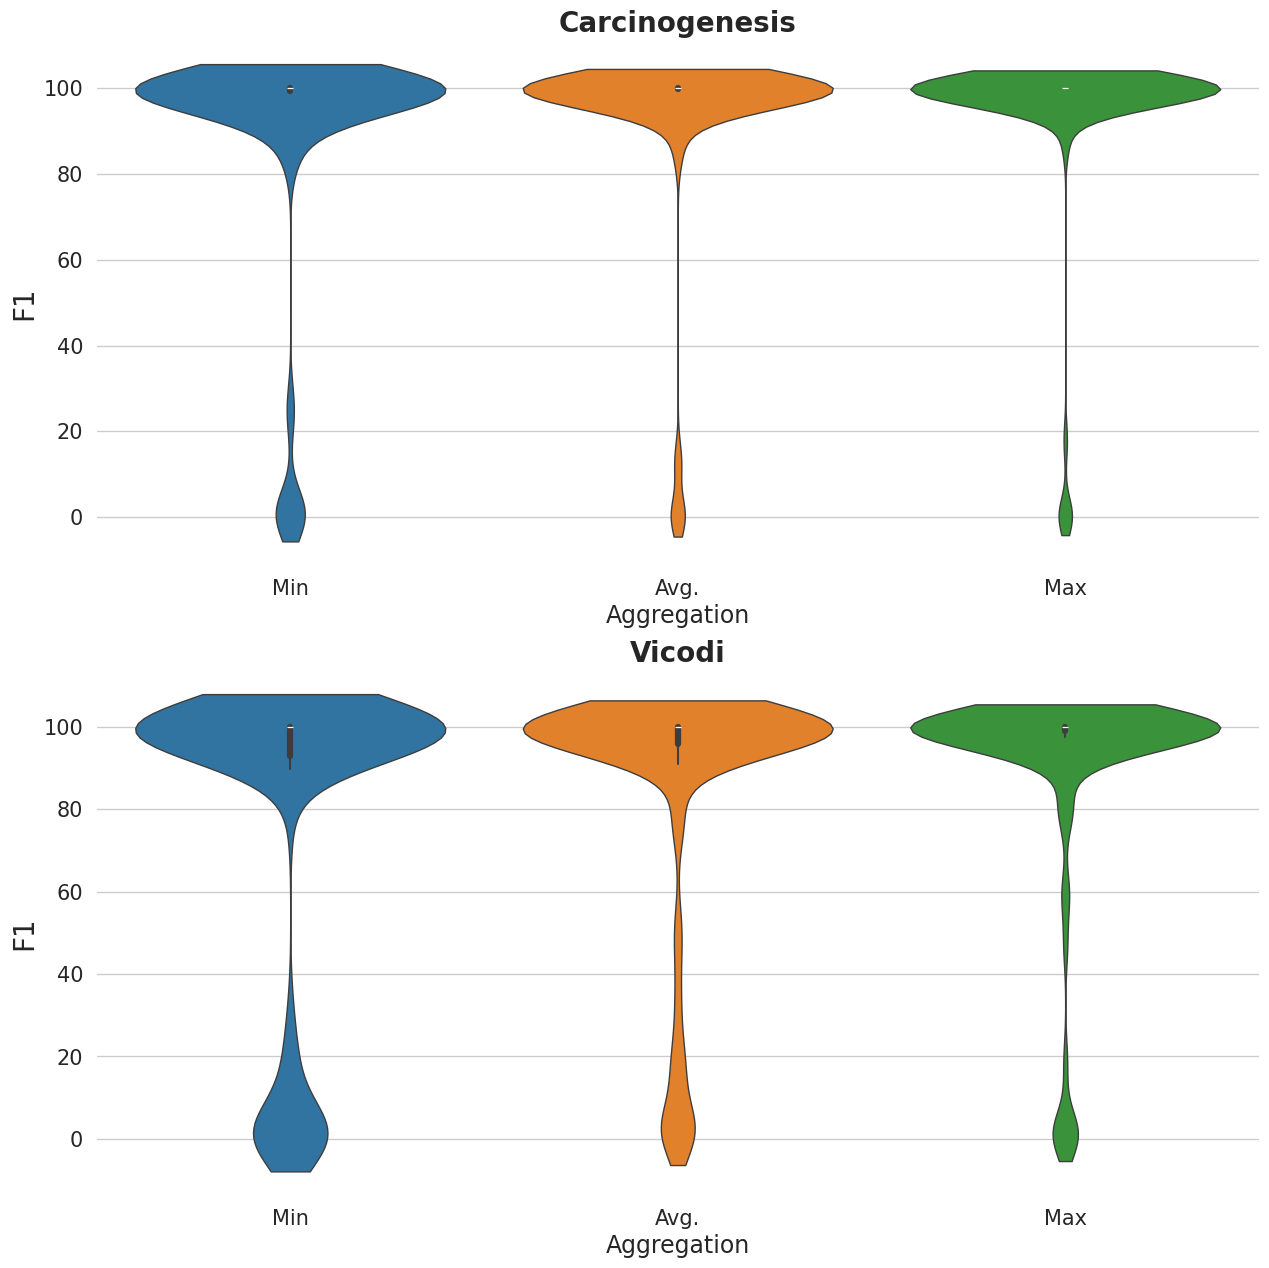

In [13]:
violin_plot()

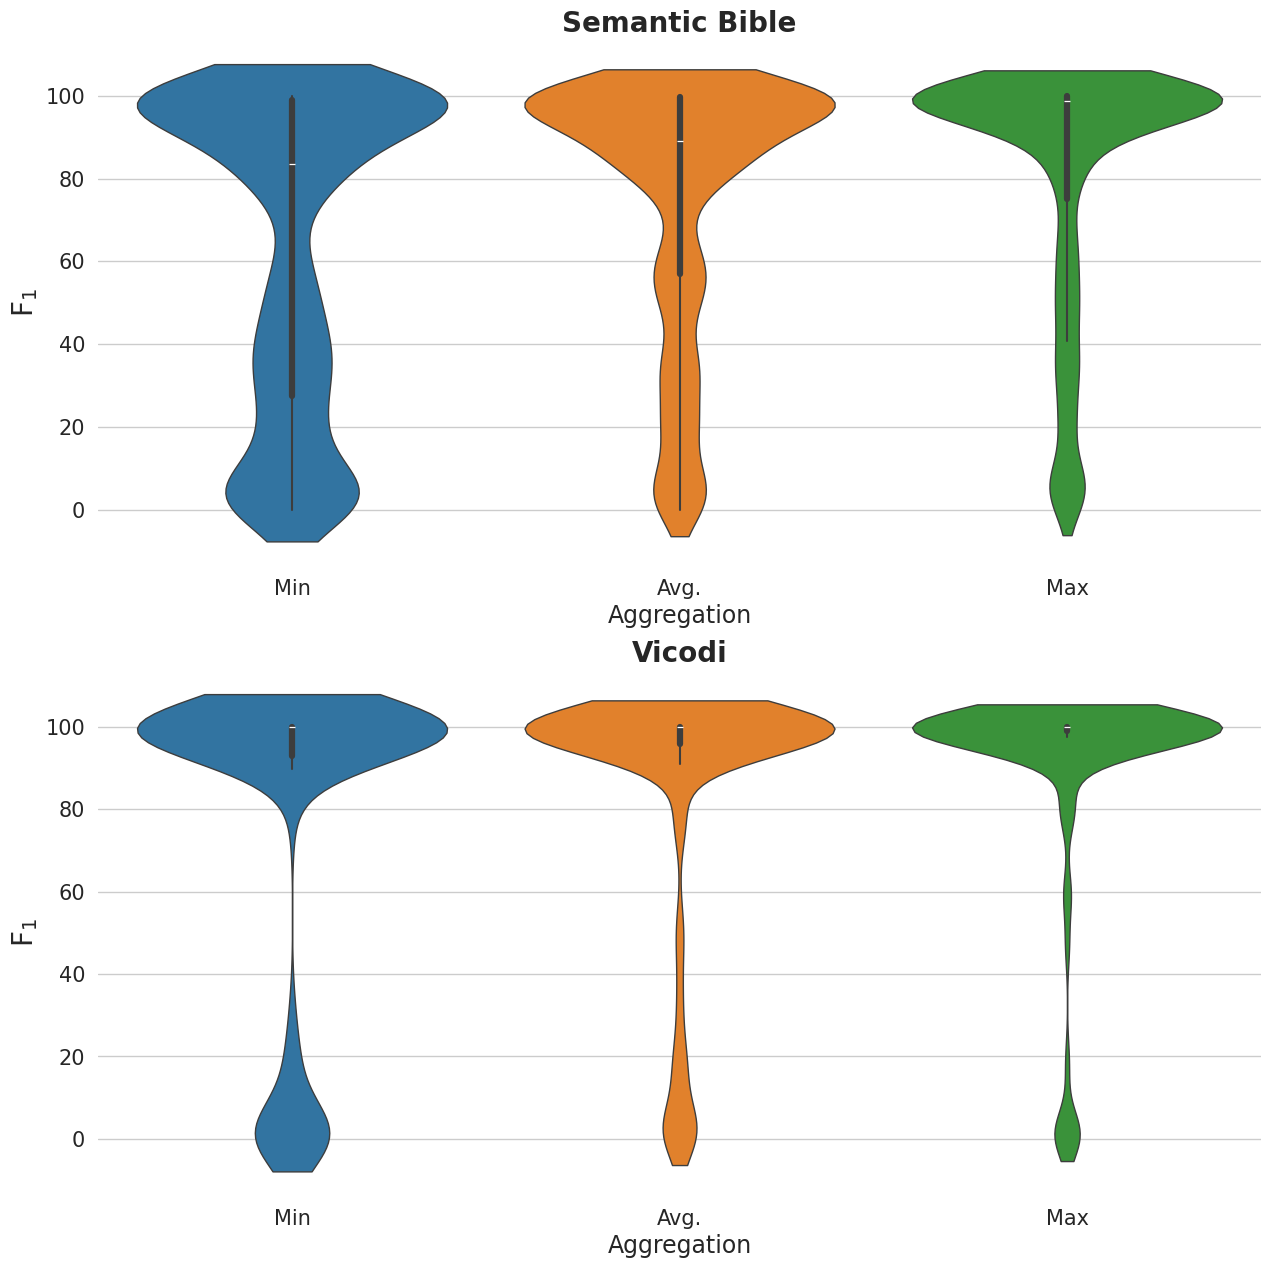

In [9]:
 violin_plot(last=True)

### Standard deviation

In [3]:
import json, numpy as np

In [4]:
with open(f"datasets/carcinogenesis/RQ3_F1.json") as file:
    data1 = np.array(list(json.load(file).values()))

In [5]:
with open(f"datasets/vicodi/RQ3_F1.json") as file:
    data2 = np.array(list(json.load(file).values()))

In [21]:
data1.std(axis=0).mean()

1.307669957277256

In [20]:
data2.std(axis=0).mean()

2.980121428655435

In [19]:
data2.mean(0)

array([9.758500e+01, 5.249042e+01, 1.140000e-01, 1.000000e+02,
       9.980596e+01, 1.000000e+02, 1.000000e+02, 1.000000e+02,
       9.965400e+01, 1.000000e+02, 7.857100e+01, 9.357100e+01,
       1.000000e+02, 1.000000e+02, 1.000000e+02, 1.000000e+02,
       1.826900e+01, 9.860432e+01, 9.999144e+01, 1.000000e+02,
       1.000000e+02, 1.000000e+02, 1.000000e+02, 1.000000e+02,
       2.700060e+01, 1.000000e+02, 4.673362e+01, 9.434000e+01,
       1.000000e+02, 1.000000e+02, 1.000000e+02, 9.894700e+01,
       9.991426e+01, 1.000000e+02, 9.706090e+01, 9.984180e+01,
       1.000000e+02, 9.985000e+01, 1.000000e+02, 9.885100e+01,
       1.000000e+02, 9.750400e+01, 9.689994e+01, 1.565944e+01,
       1.000000e+02, 1.000000e+02, 2.400000e-02, 6.454140e+00,
       9.592000e-02, 9.411800e+01, 1.000000e+02, 1.000000e+02,
       1.000000e+02, 1.000000e+02, 1.730000e+00, 1.000000e+02,
       1.000000e+02, 1.000000e+02, 1.000000e+02, 1.000000e+02,
       9.999800e+01, 1.686000e+00, 1.000000e+02, 1.1500